81
Number of samples in each bin:  [18. 60.  0.  0.  0.  0.  0.  0.  0. 81.]
Bin edges:  [3037.  3211.9 3386.8 3561.7 3736.6 3911.5 4086.4 4261.3 4436.2 4611.1
 4786. ]
Number of bar patches:  10


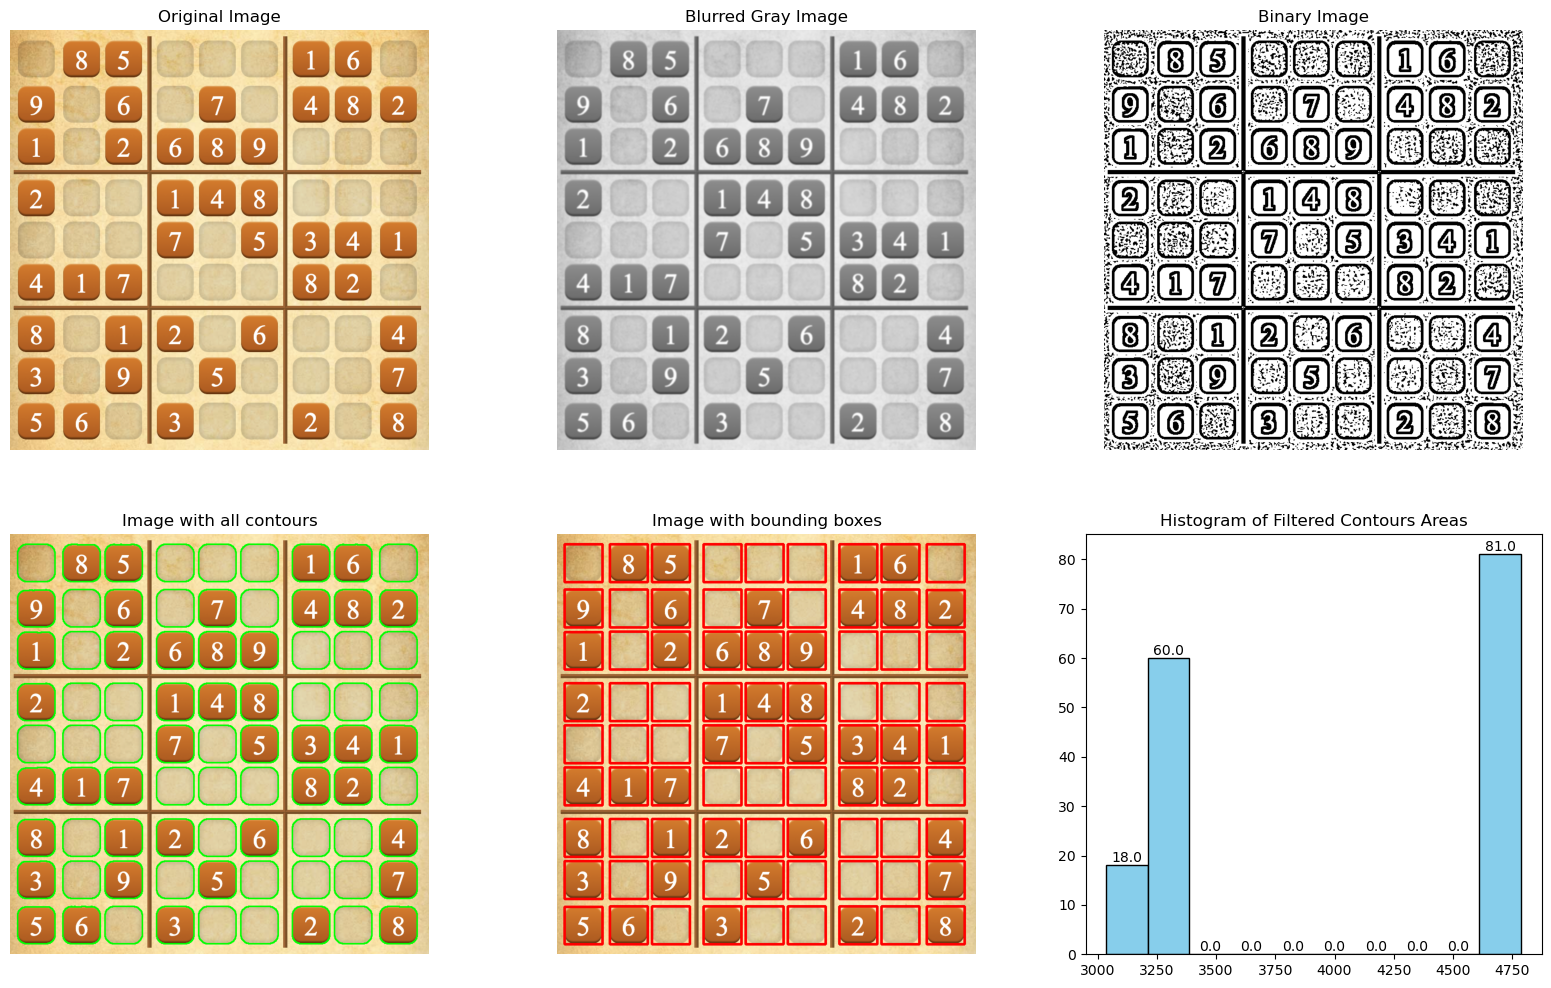

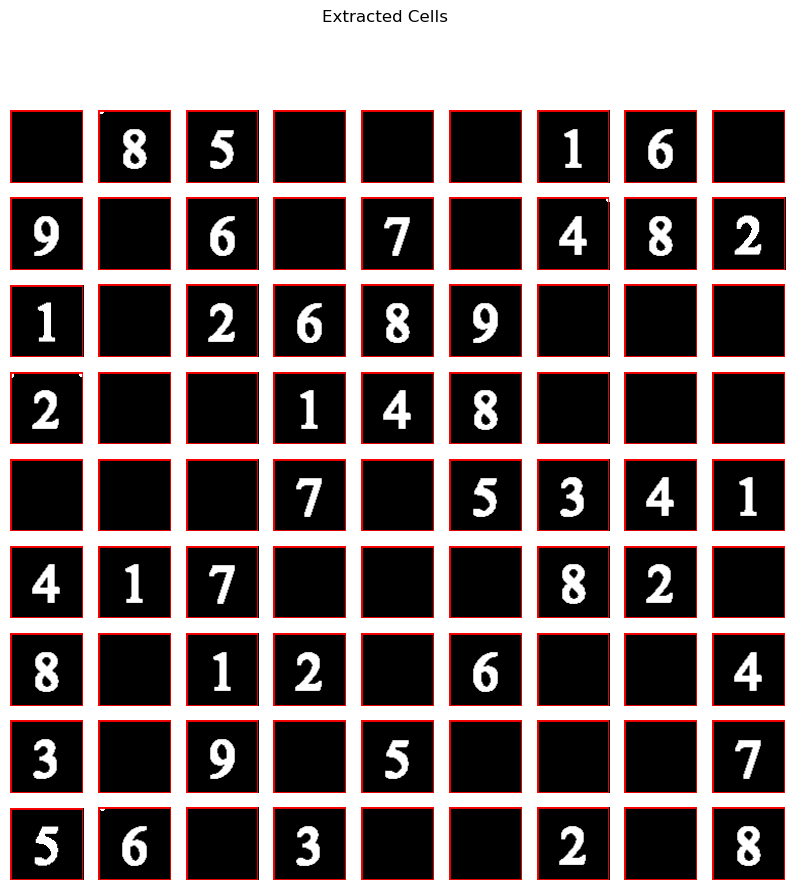

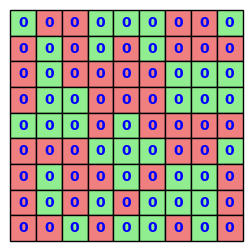

Precision: 0.4691358024691358


In [27]:
# cSpell:disable
import cv2
import numpy as np
import pytesseract
import matplotlib.patches as patches
import matplotlib.pyplot as plt

""" 
If the Sudoku grid has no borders, first identify all the small square contours (the individual cells), 
and then combine these to form the overall grid.
"""
# 2 row, 3 column grid of plots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
sudoku_img_path = "samples/sudoku-5.png"
img = cv2.imread(sudoku_img_path)
axs[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0][0].set_title("Original Image")
axs[0][0].axis("off")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
axs[0][1].imshow(cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB))
axs[0][1].set_title("Blurred Gray Image")
axs[0][1].axis("off")
binary_img = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
)
axs[0][2].imshow(cv2.cvtColor(binary_img, cv2.COLOR_BGR2RGB))
axs[0][2].set_title("Binary Image")
axs[0][2].axis("off")

contours, hierarchy = cv2.findContours(
    binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

img_area = img.shape[0] * img.shape[1]


def is_square_contour(c):
    """
    Check if a contour is square by comparing its area to its bounding rectangle.
    """
    area = cv2.contourArea(c)
    x, y, width, height = cv2.boundingRect(c)
    boundingBoxArea = width * height
    return 0.8 <= width / height <= 1.2 and area / boundingBoxArea >= 0.8


def is_contour_good(c):
    """
    This function checks if a contour is a good candidate for a Sudoku grid.
    A contour is considered a good candidate if:
    - Its area is between 80 and 95% of the area of the image.
    - It has 4 side.
    Returns a tuple of 3 values:
    - A boolean indicating if the contour is a good candidate.
    - The area of the contour.
    - The approximated shape of the contour.
    """
    # calculating the perimeter (or arc length) of the contour.
    # The second argument True indicates that the contour is closed.
    perimeter = cv2.arcLength(c, True)
    # approximating the shape of the contour
    # resolution parameter (0.02 * perimeter) is the maximum distance from the contour to the approximated contour.
    # It is an accuracy parameter. A small value gives a more accurate approximation, a large value gives a more general approximation.
    # A good rule of thumb is less than 5% of the perimeter of the contour.
    # approx is a list of points that define the polygon
    approx = cv2.approxPolyDP(c, 0.03 * perimeter, True)
    # Calculate aspect ratio
    x, y, width, height = cv2.boundingRect(approx)
    aspect_ratio = float(width) / height
    area = cv2.contourArea(c)
    return (
        # ignore small contours and contours that are too big
        # Check if aspect ratio is approximately 1
        4200 < area < 5000 and 0.8 <= aspect_ratio <= 1.2,
        area,
        approx,
    )


selected_contours = [c for c in contours if is_contour_good(c)[0]]
print(len(selected_contours))
img_with_all_contours = cv2.drawContours(
    img.copy(), selected_contours, -1, (0, 255, 0), 2
)
axs[1][0].imshow(cv2.cvtColor(img_with_all_contours, cv2.COLOR_BGR2RGB))
axs[1][0].set_title("Image with all contours")
axs[1][0].axis("off")
img_with_bounding_boxes = img.copy()
# Calculate the average height of the bounding boxes
boundingBoxes = [cv2.boundingRect(c) for c in selected_contours]
assert len(boundingBoxes) == 81, f"Expected 81 bounding boxes, got {len(boundingBoxes)}"
average_height = sum([h for (_, _, _, h) in boundingBoxes]) / len(boundingBoxes)
# sort the boxes row by row
boundingBoxes = sorted(
    boundingBoxes,
    # sort by row number(calculated by dividing the y-coordinate by the height) and then x-coordinate
    key=lambda rect: (rect[1] // average_height, rect[0]),
)
cropped_images = []
for x, y, w, h in boundingBoxes:
    # Draw the bounding box for each cell
    cv2.rectangle(img_with_bounding_boxes, (x, y), (x + w, y + h), (0, 0, 255), 3)
    # Crop the cell from the image
    cropped_images.append(binary_img[y : y + h, x : x + w])

axs[1][1].imshow(cv2.cvtColor(img_with_bounding_boxes, cv2.COLOR_BGR2RGB))
axs[1][1].set_title("Image with bounding boxes")
axs[1][1].axis("off")

# experiment 
# cell should be a square
filtered_contours = [c for c in contours if is_square_contour(c)]
filtered_contours_areas = [cv2.contourArea(c) for c in filtered_contours]
# remove outliers by filtering out contours with areas that are too large
filtered_contours_areas = [area for area in filtered_contours_areas if area < img_area / 81]
axs[1][2].set_title("Histogram of Filtered Contours Areas")
samples,bin_edges,bar_patches = axs[1][2].hist(filtered_contours_areas, color='skyblue', edgecolor='black')
print("Number of samples in each bin: ", samples)
print("Bin edges: ", bin_edges) #  For example, if you have bins at 0-10, 10-20, and 20-30, the bin edges will be [0, 10, 20, 30].
print("Number of bar patches: ", len(bar_patches))
# Add frequency number on each bin
# Each barPatch is a Patch object, which is a representation of the rectangle corresponding to the histogram bar.
# These can be used to manipulate the properties of the individual bars in the histogram (like color, border, etc.).
for i in range(len(bar_patches)):
    axs[1][2].text(bar_patches[i].get_x() + bar_patches[i].get_width() / 2., bar_patches[i].get_height(), f'{samples[i]}', ha='center', va='bottom')

# end experiment
plt.show()


# =========================== OCR ===========================
groundTruthCellValues5 = (
    "085000160906070482102689000200148000000705341417000820801206004309050007560300208"
)
groundTruthCellValues = groundTruthCellValues5
fig, axs = plt.subplots(9, 9, figsize=(10, 10))
fig.suptitle("Extracted Cells")
# draw a border around each subplot
for ax in axs.flat:
    rect = patches.Rectangle(
        (0, 0),
        1,
        1,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
        transform=ax.transAxes,
    )
    ax.add_patch(rect)

pytesseract.pytesseract.tesseract_cmd = (
    "C:/Users/xuwu/AppData/Local/Programs/Tesseract-OCR/tesseract.exe"
)

# Extract cell values
cell_values = []
for i, cell in enumerate(cropped_images):
    # Preprocess the cell image for OCR
    # when cv2.THRESH_OTSU is used, the second argument is ignored and Otsu's binarization method is used to
    # automatically calculate an optimal threshold value.
    # _, cell = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # kernel = np.ones((3,3),np.uint8)
    # cell = cv2.erode(cell, kernel, iterations = 1)
    # cell = cv2.GaussianBlur(cell, (3, 3), 0)
    # contours, hierarchy = cv2.findContours(cell, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # cell = cv2.drawContours(cell, contours, -1, (0, 0, 0), 1)
    r, c = divmod(i, 9)
    contours, hierarchy = cv2.findContours(cell, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contour_areas = [cv2.contourArea(contour) for contour in contours]
    # Sort the contours by area (in descending order)
    sorted_contours = sorted(
        zip(contour_areas, contours), key=lambda x: x[0], reverse=True
    )
    # if there are more than 15 contours, it's likely that the cell is empty
    if len(sorted_contours) > 15:
        contours = []
    elif len(sorted_contours) > 4:
        # keep the 5 largest contours to reduce noise
        _, contours = zip(*sorted_contours[4:9])

    cell = cv2.drawContours(
        np.zeros(cell.shape, np.uint8), contours, -1, (255, 255, 255), -1
    )
    # cell = cv2.GaussianBlur(cell, (3, 3), 0)
    kernel = np.ones((3, 3), np.uint8)
    cell = cv2.dilate(cell, kernel, iterations=1)
    # Invert the colors of the cell
    # cell = cv2.bitwise_not(cell)

    axs[r][c].imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
    axs[r][c].axis("off")
    # Use Tesseract to recognize the number
    config = "--psm 10 --oem 3 -c tessedit_char_whitelist=123456789"
    # value = pytesseract.image_to_string(cell, config=config)
    value = "0"
    cell_values.append(value.strip() if value.strip() else "0")
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.axis("off")
table = ax.table(
    cellText=np.array(cell_values).reshape(9, 9), cellLoc="center", bbox=[0, 0, 1, 1]
)

for i, ocr_value in enumerate(cell_values):
    r, c = divmod(i, 9)
    cell = table[(r, c)]
    if ocr_value == groundTruthCellValues[i]:
        cell.set_facecolor("lightgreen")
    else:
        cell.set_facecolor("lightcoral")
    cell.set_text_props(weight="bold", color="blue")
plt.show()

precision = sum([1 for a, b in zip(groundTruthCellValues, cell_values) if a == b]) / 81
print(f"Precision: {precision}")
# sudoku_grid = np.array(cell_values).reshape((9, 9))
# print(sudoku_grid)